In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ot
from scipy.spatial.distance import cdist

from scipy.stats import multivariate_normal as mvn
from matplotlib import cm

from time import time
import os
import pickle

In [2]:
# from sklearn.datasets import fetch_openml

# # Load MNIST dataset using scikit-learn
# mnist = fetch_openml('mnist_784')

# # Extract features and labels
# images, labels = mnist.data, mnist.target

# np.save("data_files//mnist_data.npy", np.array(images.values))
# np.save("data_files//mnist_labels.npy", np.array(labels.values))

In [3]:
data_folder = r'D:\MNIST-digits/'

images = np.load(data_folder+"mnist_data.npy")
labels = np.load(data_folder+"mnist_labels.npy", allow_pickle=True)

In [4]:
num_sample=100 #number of sample images per digit

image_list = np.concatenate([[image.reshape(28,28) for i, image in enumerate(images) if labels[i] ==str(j)][:num_sample] for j in range(10)])
labels = np.concatenate([np.ones(num_sample)*j for j in range(10)])

In [5]:
class measure():
    
    def __init__(self, weights, locations):
        self.weights = weights
        self.locations = locations
    
    #For images
    def imshow(self):
        plt.imshow(self.weights.reshape(28,28), cmap=cm.hot_r)
        
    #For point clouds
    def plot_barycenter(self):
        est = np.zeros((28,28))

        for i in range(28):
            for j in range(28):
                #Estimate measure on grid using Gaussian Kernels
                est[i,j] = np.sum(mvn.pdf(self.locations, mean=[i,j],cov=np.eye(2))*self.weights)
                
        plt.imshow(est, cmap=cm.hot_r)
        
        
def locations_update(barycenter, measure_list, Pi_list):
        
    return np.mean(np.array([measure_list[i].locations.T@Pi_list[i].T@np.diag(1/barycenter.weights.reshape(-1)) for i in range(len(measure_list))]),0).T

    
def free_support_barycenter_update(measure_list, barycenter=None, N=20):
    
    if barycenter==None:
        init_weights = np.ones((N,1))/N
        init_locations = np.zeros(3)+np.random.normal(size=(N,3))
        barycenter = measure(init_weights, init_locations)
        
    else:
    
        result_list = [wasserstein_type_distance(barycenter, measure) for measure in measure_list]
        Pi_list = [result[1][0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1][1]['u'],result[1][1]['v'])[0] for result in result_list]
        
        barycenter.means_ = means_update(barycenter, measure_list, Pi_list)
        barycenter.covariances_ = covariance_update(space, barycenter, measure_list, Pi_list)
        
        barycenter.weights_ = weights_update(barycenter, alpha_list)
    
    return barycenter


def weights_update(barycenter, alpha_list, lr=0.00005):
    
    #get subgradient
    alpha = np.mean(np.array(alpha_list),0)

    #calculate subgradient update
    a_star = barycenter.weights+(lr*alpha.reshape(1,-1))

    #project a_star into (interior of) probability simplex
    a_star[a_star<0]=0.000001
    a = a_star/np.sum(a_star)
    
    return a.reshape(-1)
        
class measure_network():
    
    def __init__(self, weights, locations, sigma=1,eps=1e-15):
        self.weights = weights
        self.locations = locations
        self.D = cdist(self.locations,self.locations)
        
        
        self.eps=eps
        self.sigma = sigma 
        self.C = np.exp(-self.D ** 2 / (2 * self.sigma ** 2))
        
    def plot_graph(self):
        self.C = np.exp(-self.D ** 2 / (2 * self.sigma ** 2))
        # Plot nodes
        plt.scatter(self.locations[:, 1],-self.locations[:, 0], color='skyblue', alpha = self.weights/max(self.weights))

        # Plot edges
        for i in range(self.C.shape[0]-1):
            if self.weights[i]>0:
                for j in range(i + 1, self.C.shape[0]):
                    if self.weights[j]>0 and self.C[i,j]>self.eps:
                        plt.plot([self.locations[i, 1], self.locations[j, 1]], [-self.locations[i, 0], -self.locations[j, 0]], color='gray', alpha=self.C[i, j])                      


        # i, j = np.tril_indices(self.C.shape[0], k=-1)
        # plt.plot(np.c_[self.locations[i, 1], self.locations[j, 1]].T, -np.c_[self.locations[i, 0], self.locations[j, 0]].T, color='gray', alpha=self.C[i, j])

In [6]:
D = np.zeros((2,28,28))
for i in range(28):
    for j in range(28):
        
        D[:,i,j] = np.array([i,j])
        
coords = D.reshape(2,28*28).T

measure_list = [measure((image/np.sum(image)).flatten(), coords) for image in image_list if np.sum(image)>0]

In [7]:
def FGW_decomp(measure_list,alpha,N,num_iter=10, eps=0.001):
    
    mu0 = measure_network(np.ones(N)/N,np.random.rand(N,2)*28,sigma=2)

    for j in range(num_iter):
        t0 = time()
        
        squared_FGW_2=[]
        deterministic_component=[]
        deterministic_component_W=[]
        deterministic_component_GW=[]
        gamma_list = []
        
        nodes = []
        edges = []

        a = mu0.weights
        X = mu0.locations
        A = mu0.D
        n = a.shape[0]

        for i, measure_i in enumerate(measure_list):
            
            mu1 = measure_network(measure_i.weights, measure_i.locations,sigma=2)

            nonzero_ind = mu1.weights>0
            b = mu1.weights[nonzero_ind] #drop pixels with 0 intensity
            Y = mu1.locations[nonzero_ind] #drop pixels with 0 intensity
            B = mu1.D[nonzero_ind][:,nonzero_ind] #drop pixels with 0 intensity
            m = b.shape[0]
            
            M=np.square(cdist(X,Y))

            if alpha == 0:
                gamma = ot.emd(a,b,M)
                
            elif alpha == 1:
                gamma = ot.gromov_wasserstein(A,B,a,b)
                
            else:
                gamma = ot.fused_gromov_wasserstein(M, A, B, a, b, 'square_loss', alpha=alpha, tol_rel=1e-9)
                
            gamma_list.append(gamma)

            Tx = np.diag(1/a)@gamma@Y
            # C = np.einsum('ij,kl,jl->ik', gamma/a[:, None], gamma/a[:, None], B)
            C = np.multiply(1/(a[None,:]*a[:,None]),(gamma@B@gamma.T))
            
            temp = np.square(A[:,None,:,None]-B[None,:,None,:])
            squared_FGW_2.append((1-alpha)*np.sum(gamma*M) + alpha*(np.sum(np.einsum('ij,kl,ijkl->ijkl', gamma, gamma, temp))))
            
            deterministic_component_W.append((1-alpha)*np.sum(a*np.square(np.linalg.norm(X - Tx, axis=1))))
            deterministic_component_GW.append(alpha*(a.T@np.square(A-C)@a))
            deterministic_component.append((1-alpha)*np.sum(a*np.square(np.linalg.norm(X - Tx, axis=1))) + alpha*(a.T@np.square(A-C)@a))

            
            nodes.append(Tx)                     
            edges.append(C)

        node_barycenter = np.array(nodes).mean(0)
        edge_barycenter = np.array(edges).mean(0)

        mu0 = measure_network(mu0.weights,node_barycenter,sigma=2)
        mu0.D = edge_barycenter
        
        var_FGW = np.mean(np.array(squared_FGW_2))
        
        if j>0:
            if var_FGW_last<=var_FGW:
                print("Iteration "+str(j+1)+": " +str(np.mean(np.array(deterministic_component))/np.mean(np.array(squared_FGW_2)))+", "+str(round(time()-t0,2))+" seconds")
                return mu0_last, np.array(squared_FGW_2_last), np.array(deterministic_component_last), np.array(deterministic_component_W_last), np.array(deterministic_component_GW_last), gamma_list_last, np.array(nodes_last), np.array(edges_last)
        
        mu0_last = mu0
        var_FGW_last = var_FGW
        squared_FGW_2_last = squared_FGW_2
        deterministic_component_last = deterministic_component
        deterministic_component_W_last = deterministic_component_W
        deterministic_component_GW_last = deterministic_component_GW
        gamma_list_last = gamma_list
        nodes_last = nodes
        edges_last = edges
        
        print("Iteration "+str(j+1)+": " +str(np.mean(np.array(deterministic_component))/np.mean(np.array(squared_FGW_2)))+", "+str(round(time()-t0,2))+" seconds")
        
    return mu0, np.array(squared_FGW_2), np.array(deterministic_component), np.array(deterministic_component_W), np.array(deterministic_component_GW), gamma_list, np.array(nodes), np.array(edges)
        
        
def vectorize_structured_data(nodes, edges, mu0):
    n = nodes.shape[0]
    N = nodes.shape[1]

    # vectorize node positions
    flattened_nodes = nodes.reshape(n, -1)

    # vectorize edges (upper triangle of cost matrix)
    upper_triangle_indices = np.triu_indices(N)
    flattened_upper_triangle_edges = edges[:, upper_triangle_indices[0], upper_triangle_indices[1]]
    
    # vectorize nodes and edges of barycenter
    flattened_barycenter_nodes = mu0.locations.reshape(1,-1)
    flattened_barycenter_edges = mu0.D[upper_triangle_indices[0], upper_triangle_indices[1]]

    # Step 3: Concatenate the results along the second dimension
    return np.concatenate((flattened_nodes - flattened_barycenter_nodes, flattened_upper_triangle_edges - flattened_barycenter_edges), axis=1)

def fgw_barycentric_projection(target, source, alpha):
    
    #get source info
    a = source.weights
    X = source.locations
    A = source.D
    n = a.shape[0]

    #get target info
    nonzero_ind = target.weights>0
    b = target.weights[nonzero_ind] #drop pixels with 0 intensity
    Y = target.locations[nonzero_ind] #drop pixels with 0 intensity
    B = target.D[nonzero_ind][:,nonzero_ind] #drop pixels with 0 intensity
    m = b.shape[0]
    
    M=np.square(cdist(X,Y))

    gamma = ot.fused_gromov_wasserstein(M,A, B, a, b, 'square_loss', alpha=alpha, tol_rel=1e-9)
    
    Tx = np.diag(1/a)@gamma@Y
    # C = np.einsum('ij,kl,jl->ik', gamma/a[:, None], gamma/a[:, None], B)
    C = np.multiply(1/(a[None,:]*a[:,None]),(gamma@B@gamma.T))

    barycentric_projection = measure_network(source.weights, Tx, sigma=2)
    barycentric_projection.D = C
    
    return barycentric_projection

Experiment N = 1 , alpha = 0
Iteration 1: 0.8114036374241922, 12.34 seconds
Iteration 2: 0.0034714714505544985, 12.82 seconds
Iteration 3: 0.0034714714505544985, 12.4 seconds
0.091 Experiment N = 1 , alpha = 0.25
Iteration 1: 0.5685359095691738, 12.86 seconds
Iteration 2: 0.008317151277542551, 12.98 seconds
Iteration 3: 0.008317151277542553, 13.25 seconds
0.257 Experiment N = 1 , alpha = 0.5
Iteration 1: 0.6374476511174751, 12.82 seconds
Iteration 2: 0.01482763027188682, 12.87 seconds
Iteration 3: 0.014827630271886823, 12.86 seconds
0.257 Experiment N = 1 , alpha = 0.75
Iteration 1: 0.7376717410259666, 12.82 seconds
Iteration 2: 0.02403880280163576, 15.19 seconds
Iteration 3: 0.024038802801635756, 14.04 seconds
0.257 Experiment N = 1 , alpha = 1
Iteration 1: 0.7641924155245302, 13.06 seconds
Iteration 2: 0.038070889411095994, 13.32 seconds
Iteration 3: 0.038070889411096, 14.84 seconds
0.268  


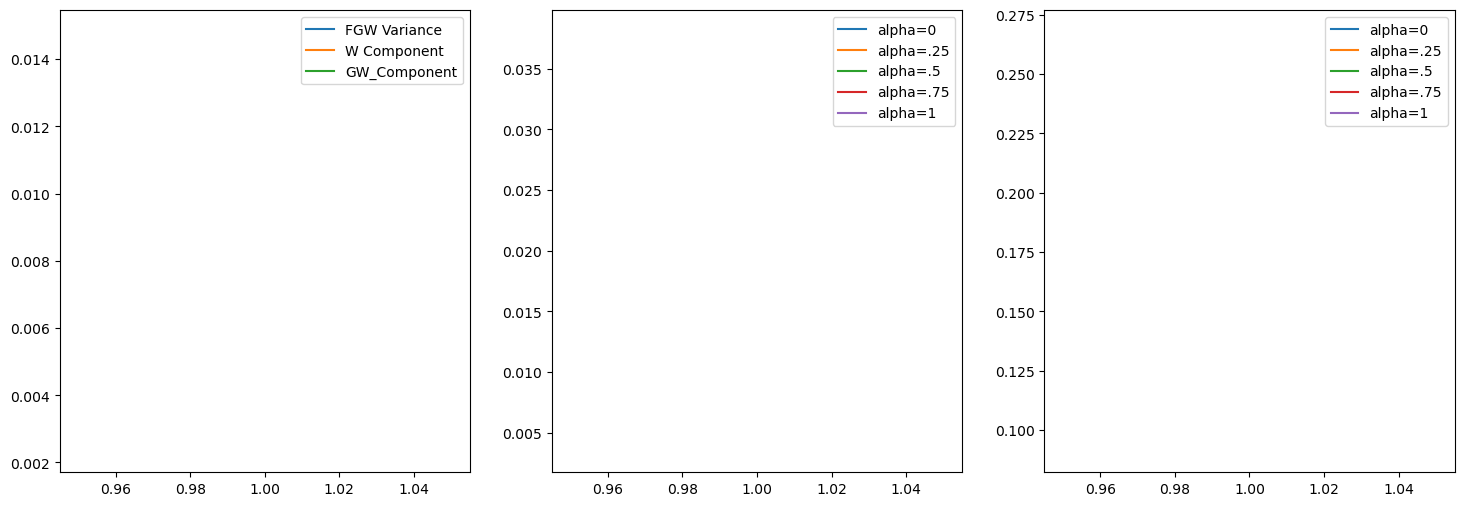

Experiment N = 2 , alpha = 0
Iteration 1: 0.8034538688938185, 12.96 seconds
Iteration 2: 0.09640999190230252, 12.81 seconds
Iteration 3: 0.09703131319830959, 13.05 seconds
Iteration 4: 0.09724007735008935, 13.44 seconds
Iteration 5: 0.09768730413018586, 13.06 seconds
Iteration 6: 0.09765291780031443, 12.97 seconds
Iteration 7: 0.09765291780031443, 13.05 seconds
0.283 Experiment N = 2 , alpha = 0.25
Iteration 1: 0.45035437137556983, 14.62 seconds
Iteration 2: 0.18317364536965003, 14.46 seconds
Iteration 3: 0.18532790277930827, 14.12 seconds
Iteration 4: 0.16941639012438153, 14.02 seconds
Iteration 5: 0.12372043503440465, 14.04 seconds
Iteration 6: 0.10591938849877626, 14.0 seconds
Iteration 7: 0.10411120195899569, 14.32 seconds
Iteration 8: 0.10385558936567968, 14.35 seconds
Iteration 9: 0.10403227261194972, 14.2 seconds
Iteration 10: 0.10385946686961052, 14.17 seconds
0.611 Experiment N = 2 , alpha = 0.5
Iteration 1: 0.8198219391092826, 14.89 seconds
Iteration 2: 0.151830289458416, 14.

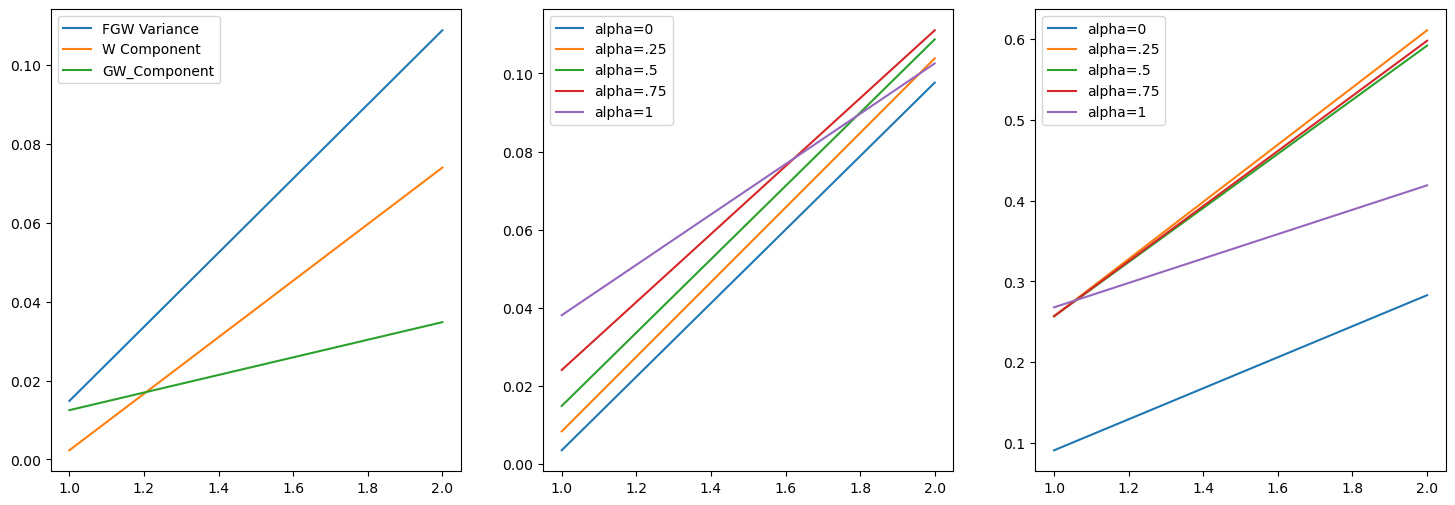

Experiment N = 3 , alpha = 0
Iteration 1: 0.8711354952245133, 14.2 seconds
Iteration 2: 0.1982155844454238, 14.16 seconds
Iteration 3: 0.19669196492281332, 14.25 seconds
Iteration 4: 0.19721635536314788, 14.66 seconds
Iteration 5: 0.19862431303145445, 14.25 seconds
Iteration 6: 0.20011533496087, 14.33 seconds
Iteration 7: 0.20131290664547083, 14.31 seconds
Iteration 8: 0.2027117093835967, 14.25 seconds
Iteration 9: 0.20229784667442718, 14.11 seconds
Iteration 10: 0.20314204889865398, 14.4 seconds
0.658 Experiment N = 3 , alpha = 0.25
Iteration 1: 0.8527383276698982, 16.06 seconds
Iteration 2: 0.21811979948506457, 15.67 seconds
Iteration 3: 0.21719297585019118, 15.68 seconds
Iteration 4: 0.2170538098224946, 15.84 seconds
Iteration 5: 0.21666062817766818, 16.04 seconds
Iteration 6: 0.21601142709400648, 15.92 seconds
Iteration 7: 0.21492861311631778, 16.01 seconds
Iteration 8: 0.21460924214297813, 16.31 seconds
Iteration 9: 0.21465367126525858, 15.98 seconds
Iteration 10: 0.21438710130802

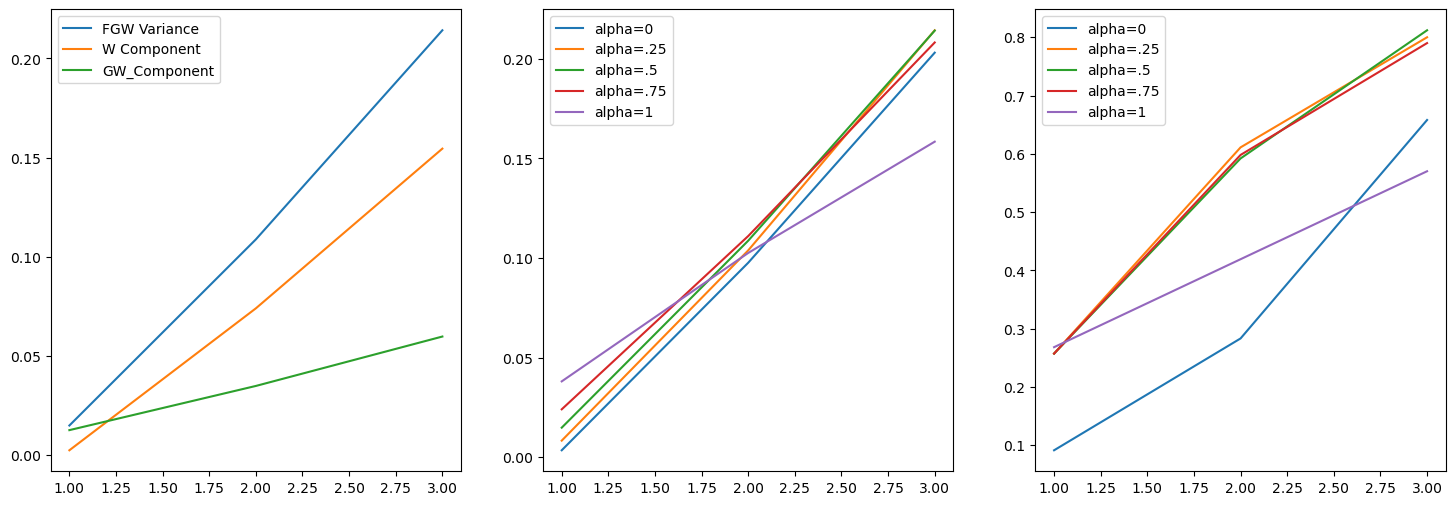

Experiment N = 4 , alpha = 0
Iteration 1: 0.7964136631085839, 17.27 seconds
Iteration 2: 0.2806398279608078, 16.93 seconds
Iteration 3: 0.27764530476237526, 16.81 seconds
Iteration 4: 0.280962380766809, 17.29 seconds
Iteration 5: 0.28278738675737486, 17.76 seconds
Iteration 6: 0.2910768944195941, 19.72 seconds
Iteration 7: 0.296800440482817, 18.75 seconds
Iteration 8: 0.29489344152927444, 17.75 seconds
Iteration 9: 0.298093958932009, 17.74 seconds
Iteration 10: 0.2991964884749136, 17.69 seconds
0.709 Experiment N = 4 , alpha = 0.25
Iteration 1: 0.7968737456379967, 19.03 seconds
Iteration 2: 0.28252488069584697, 18.95 seconds
Iteration 3: 0.27954689140814765, 20.02 seconds
Iteration 4: 0.28011254928962254, 19.03 seconds
Iteration 5: 0.2847722517193387, 19.2 seconds
Iteration 6: 0.28231058446798396, 19.06 seconds
Iteration 7: 0.2871134426977623, 19.22 seconds
Iteration 8: 0.29114683369657485, 18.86 seconds
Iteration 9: 0.2960565948050106, 19.01 seconds
Iteration 10: 0.30091929971349296, 

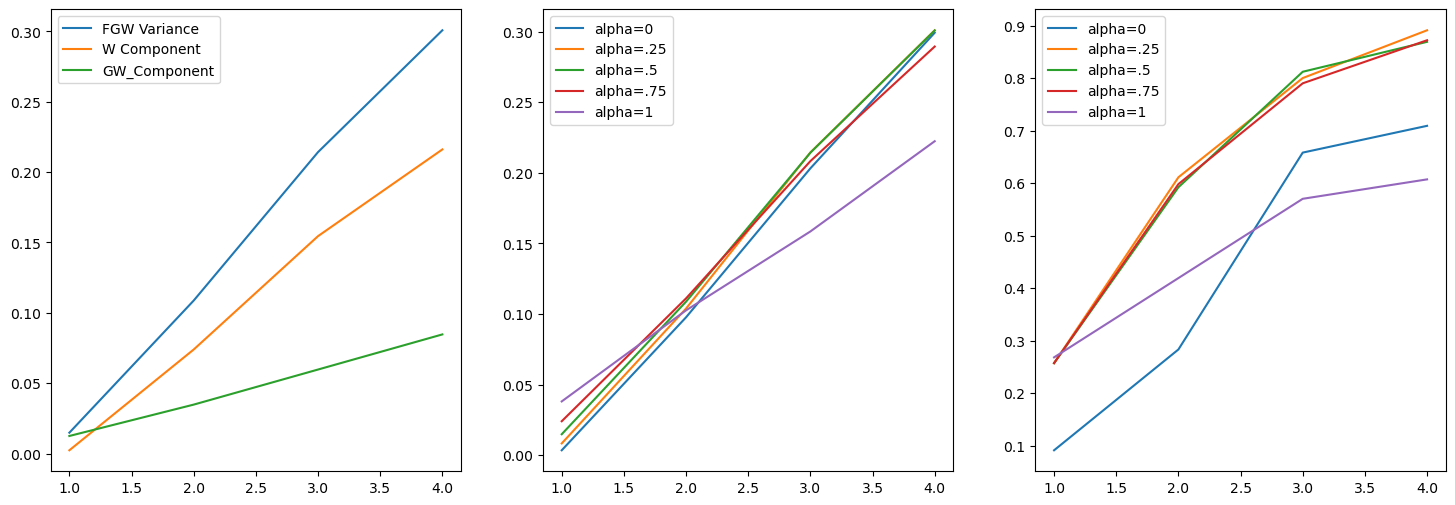

Experiment N = 5 , alpha = 0
Iteration 1: 0.8931124221612494, 19.33 seconds
Iteration 2: 0.38354070248650196, 19.57 seconds
Iteration 3: 0.3644183412931151, 19.76 seconds
Iteration 4: 0.36444836078490045, 19.49 seconds
Iteration 5: 0.36405098086492454, 20.02 seconds
Iteration 6: 0.36399350420393484, 19.82 seconds
Iteration 7: 0.3646459440834263, 19.92 seconds
Iteration 8: 0.3647036805155528, 20.24 seconds
Iteration 9: 0.3647650585369756, 20.06 seconds
Iteration 10: 0.3648132289718117, 19.82 seconds
0.784 Experiment N = 5 , alpha = 0.25
Iteration 1: 0.9167049786872309, 22.25 seconds
Iteration 2: 0.388404483884727, 21.66 seconds
Iteration 3: 0.3866966236028968, 21.78 seconds
Iteration 4: 0.37157331966163076, 21.72 seconds
Iteration 5: 0.366921742076265, 21.59 seconds
Iteration 6: 0.36588662295589786, 18.55 seconds
Iteration 7: 0.36560108603288455, 18.59 seconds
Iteration 8: 0.36586546007893317, 18.56 seconds
Iteration 9: 0.36560395931168793, 18.58 seconds
Iteration 10: 0.3652745407293594

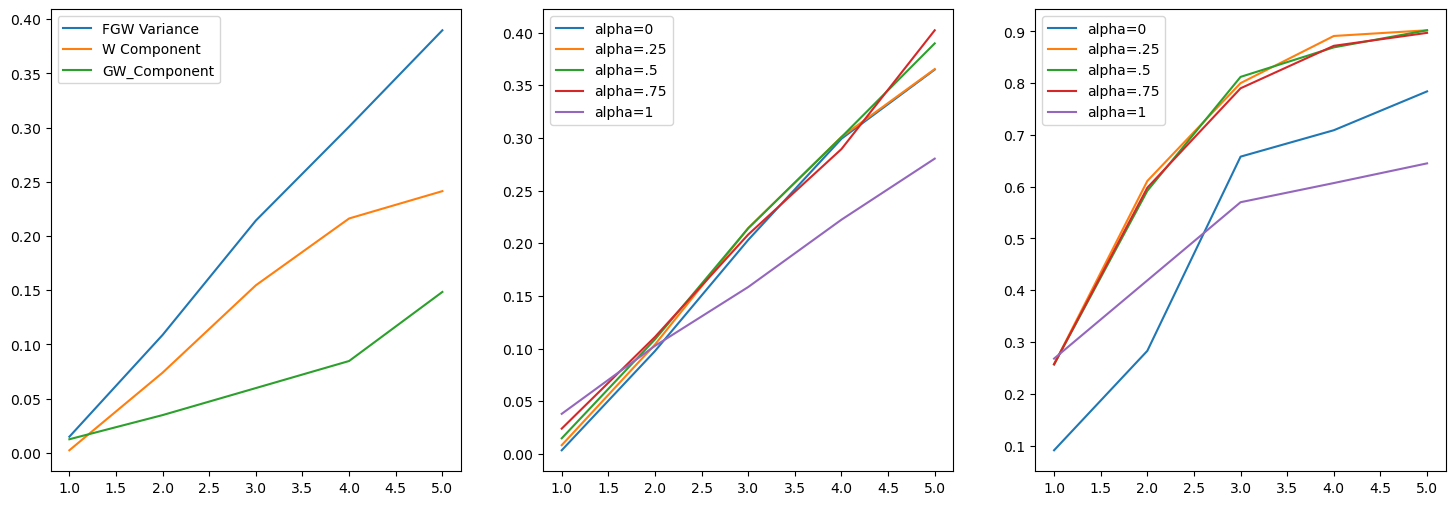

Experiment N = 6 , alpha = 0
Iteration 1: 0.9059984171798537, 23.91 seconds
Iteration 2: 0.4544200030672485, 20.2 seconds
Iteration 3: 0.42281429103746326, 18.47 seconds
Iteration 4: 0.4219096890243092, 18.47 seconds
Iteration 5: 0.42131996361071805, 19.43 seconds
Iteration 6: 0.4215511799658086, 20.09 seconds
Iteration 7: 0.4216861215116047, 19.78 seconds
Iteration 8: 0.4217405992338675, 19.45 seconds
Iteration 9: 0.42137292298479523, 19.57 seconds
Iteration 10: 0.4217959644349456, 19.47 seconds
0.822 Experiment N = 6 , alpha = 0.25
Iteration 1: 0.816786163481618, 21.27 seconds
Iteration 2: 0.4312061301163941, 21.12 seconds
Iteration 3: 0.43675610677102983, 21.12 seconds
Iteration 4: 0.4386715716568981, 21.04 seconds
Iteration 5: 0.43572447258588637, 21.37 seconds
Iteration 6: 0.4303782164783148, 20.87 seconds
Iteration 7: 0.4330253600746705, 21.32 seconds
Iteration 8: 0.4324826604810522, 21.11 seconds
Iteration 9: 0.43285261257331864, 21.23 seconds
Iteration 10: 0.4309507798472146, 2

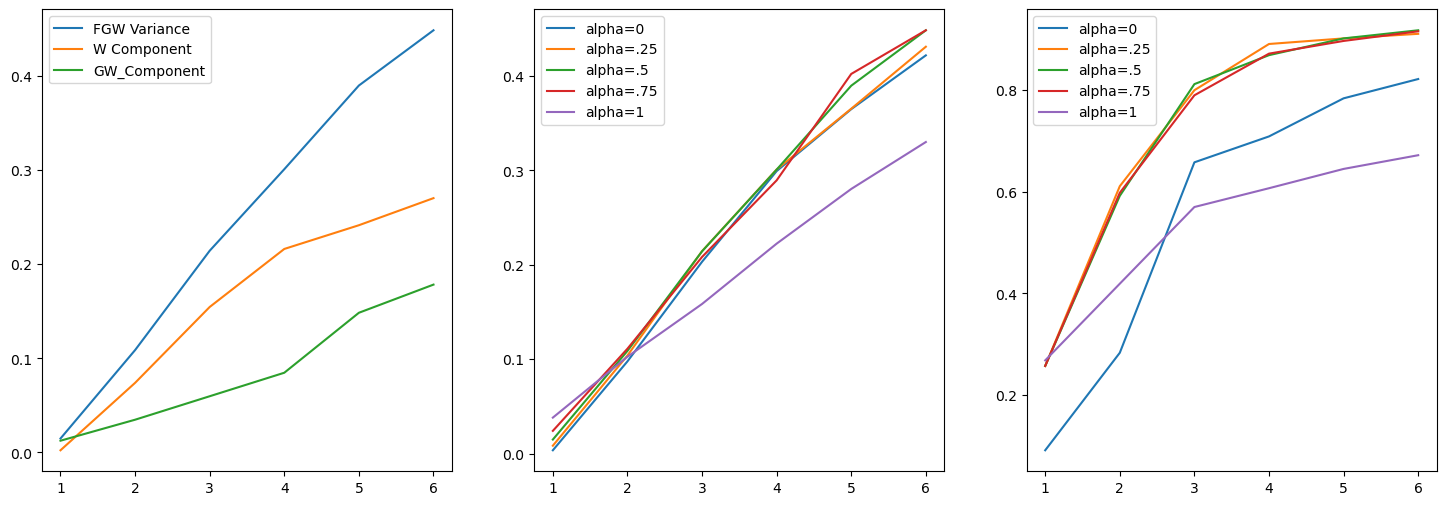

Experiment N = 7 , alpha = 0
Iteration 1: 0.7988260205614175, 27.37 seconds
Iteration 2: 0.4511620482372937, 27.43 seconds
Iteration 3: 0.4481729173589457, 27.33 seconds
Iteration 4: 0.45782328405216405, 27.19 seconds
Iteration 5: 0.47274563260667685, 27.36 seconds
Iteration 6: 0.4776545585076892, 27.04 seconds
Iteration 7: 0.4803073987090791, 27.41 seconds
Iteration 8: 0.47943042383886475, 26.89 seconds
Iteration 9: 0.4781955738683285, 27.46 seconds
Iteration 10: 0.47825507691579217, 27.1 seconds
0.84 Experiment N = 7 , alpha = 0.25
Iteration 1: 0.9296751767686579, 29.89 seconds
Iteration 2: 0.48785519661005944, 29.58 seconds
Iteration 3: 0.47026938882442937, 29.4 seconds
Iteration 4: 0.47233179923868773, 29.39 seconds
Iteration 5: 0.47095663094940676, 29.15 seconds
Iteration 6: 0.4710064267979067, 29.3 seconds
Iteration 7: 0.4710826776537016, 29.57 seconds
Iteration 8: 0.4729353389520115, 29.14 seconds
Iteration 9: 0.4723439808799924, 29.77 seconds
Iteration 10: 0.47355575191867655, 

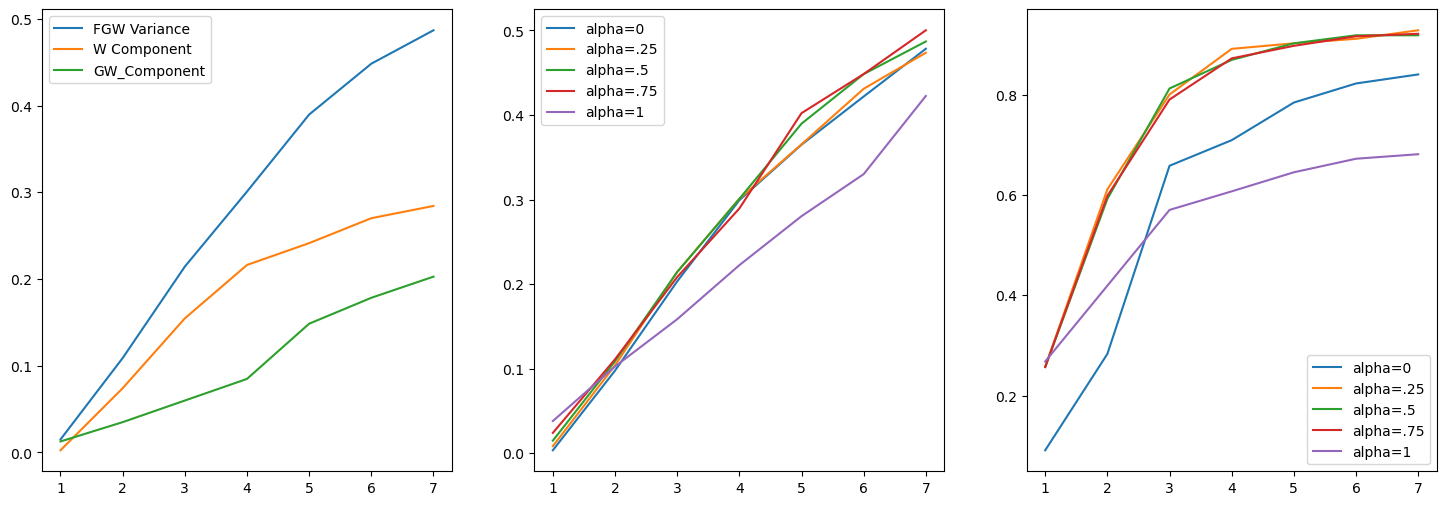

Experiment N = 8 , alpha = 0
Iteration 1: 0.9270128731299586, 30.71 seconds
Iteration 2: 0.48679784458102676, 30.04 seconds
Iteration 3: 0.4989192718515696, 29.98 seconds
Iteration 4: 0.5056111736185253, 30.13 seconds
Iteration 5: 0.5073426639492756, 30.41 seconds
Iteration 6: 0.5089951364488445, 30.27 seconds
Iteration 7: 0.5106171302007172, 29.88 seconds
Iteration 8: 0.5116686794127415, 30.79 seconds
Iteration 9: 0.5124969361864142, 30.7 seconds
Iteration 10: 0.5142839049414931, 30.85 seconds
0.867 Experiment N = 8 , alpha = 0.25
Iteration 1: 0.9119209769806113, 33.8 seconds
Iteration 2: 0.5014468439037224, 34.01 seconds
Iteration 3: 0.4975603979502768, 33.89 seconds
Iteration 4: 0.5034899066318766, 34.62 seconds
Iteration 5: 0.5078105847514033, 33.94 seconds
Iteration 6: 0.513810121449495, 33.79 seconds
Iteration 7: 0.5179570673196027, 33.88 seconds
Iteration 8: 0.5192226909787199, 33.93 seconds
Iteration 9: 0.5185803256044451, 34.21 seconds
Iteration 10: 0.5183887014666209, 34.11 s

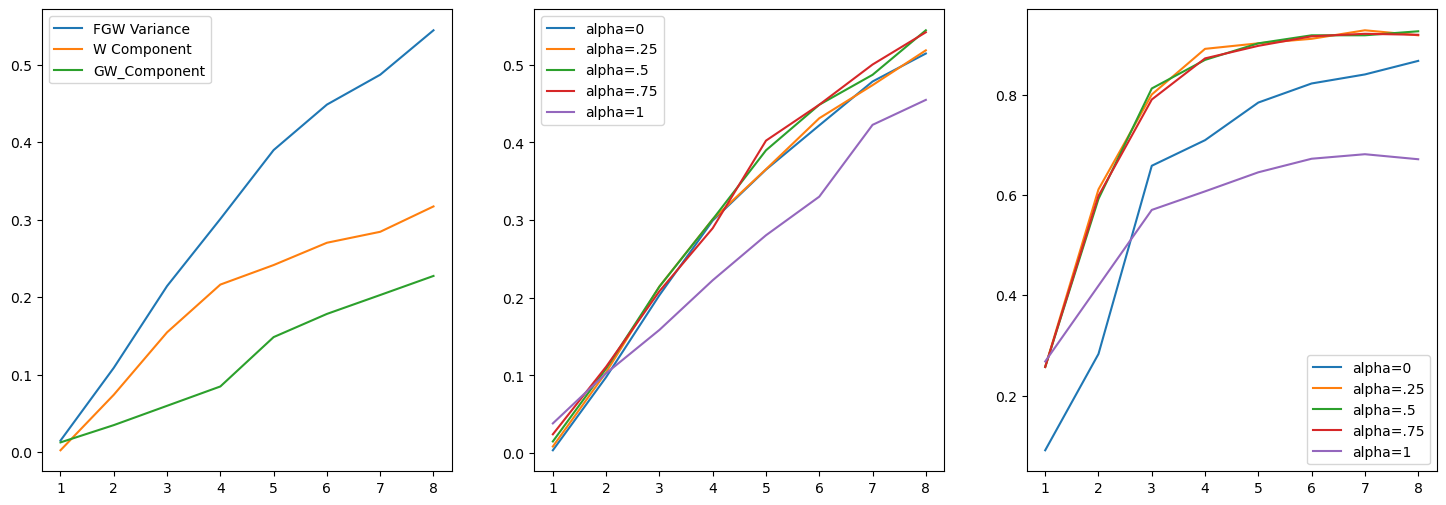

Experiment N = 9 , alpha = 0
Iteration 1: 0.9217172494972075, 36.06 seconds
Iteration 2: 0.5389356638429056, 35.76 seconds
Iteration 3: 0.5311838238969002, 35.72 seconds
Iteration 4: 0.527568485559225, 36.16 seconds
Iteration 5: 0.5267123735274286, 34.34 seconds
Iteration 6: 0.5280706478778663, 34.72 seconds
Iteration 7: 0.5299888202277915, 35.22 seconds
Iteration 8: 0.5323976213558699, 34.93 seconds
Iteration 9: 0.5354408198372803, 34.32 seconds
Iteration 10: 0.5376202501945916, 35.96 seconds
0.864 Experiment N = 9 , alpha = 0.25
Iteration 1: 0.8863242599156824, 38.8 seconds
Iteration 2: 0.5522218996634838, 39.6 seconds
Iteration 3: 0.5499503820560578, 40.78 seconds
Iteration 4: 0.5546446540903219, 39.15 seconds
Iteration 5: 0.5588371156393531, 38.65 seconds
Iteration 6: 0.562923586296375, 38.69 seconds
Iteration 7: 0.5616484432035314, 38.63 seconds
Iteration 8: 0.5622960857770959, 39.4 seconds
Iteration 9: 0.5617740429861044, 39.17 seconds
Iteration 10: 0.56174072025396, 39.05 second

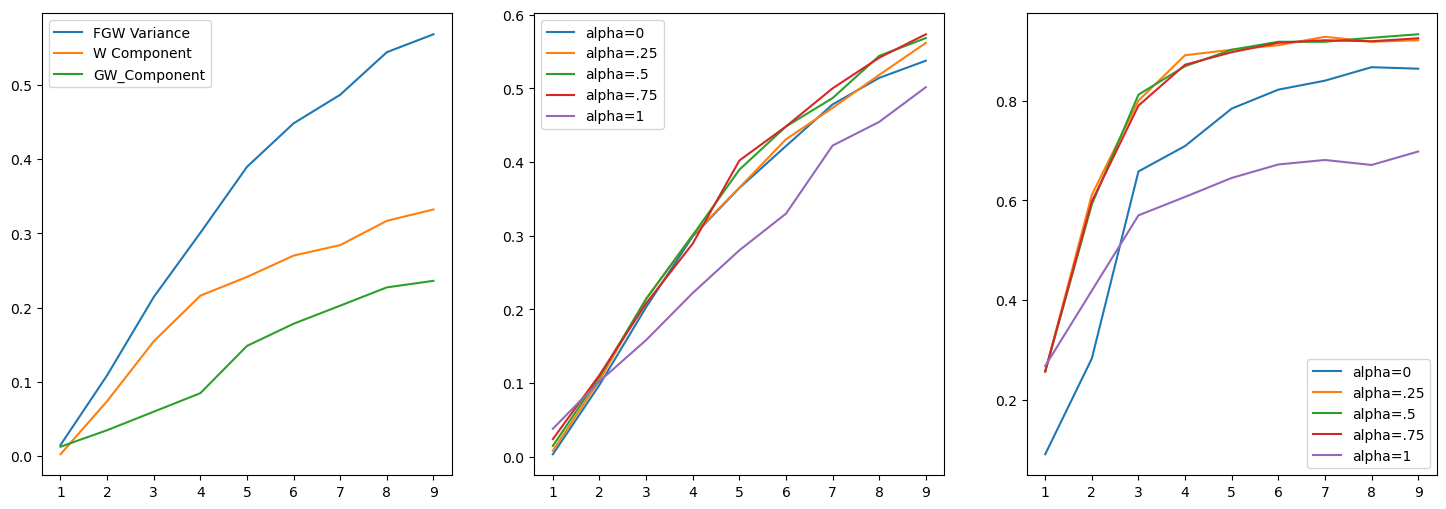

Experiment N = 10 , alpha = 0
Iteration 1: 0.9366517276956805, 43.09 seconds
Iteration 2: 0.5745655371490302, 43.09 seconds
Iteration 3: 0.5835060043903099, 42.93 seconds
Iteration 4: 0.5872990455537268, 43.1 seconds
Iteration 5: 0.5912959046959705, 42.9 seconds
Iteration 6: 0.5916670471952484, 42.65 seconds
Iteration 7: 0.5908853896001408, 41.53 seconds
Iteration 8: 0.5909202324602876, 43.03 seconds
Iteration 9: 0.5904865865888058, 42.81 seconds
Iteration 10: 0.5898737605743712, 42.2 seconds
0.872 Experiment N = 10 , alpha = 0.25
Iteration 1: 0.8895512218148418, 45.56 seconds
Iteration 2: 0.5956930053335648, 45.24 seconds
Iteration 3: 0.5880920751336612, 44.13 seconds
Iteration 4: 0.5856949265679632, 45.89 seconds
Iteration 5: 0.5862516846977837, 44.29 seconds
Iteration 6: 0.5846759451898828, 43.91 seconds
Iteration 7: 0.584727127238985, 44.09 seconds
Iteration 8: 0.5848479754960271, 44.22 seconds
Iteration 9: 0.5856881794657244, 43.79 seconds
Iteration 10: 0.5854777183503611, 44.21 s

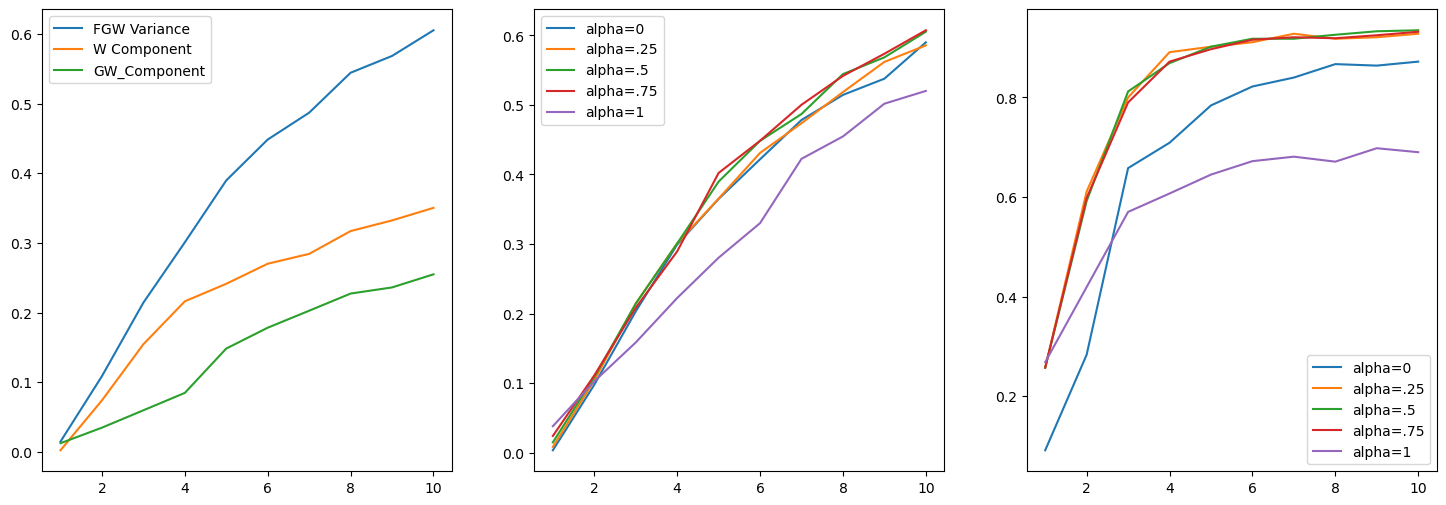

Experiment N = 11 , alpha = 0
Iteration 1: 0.9101467705858497, 47.32 seconds
Iteration 2: 0.576995909798541, 47.46 seconds
Iteration 3: 0.5791344802832536, 47.35 seconds
Iteration 4: 0.5894759465843799, 47.53 seconds
Iteration 5: 0.6023930632125648, 47.9 seconds
Iteration 6: 0.6116650708498216, 47.93 seconds
Iteration 7: 0.6159897618109993, 47.79 seconds
Iteration 8: 0.6170599216443444, 47.81 seconds
Iteration 9: 0.618364110277436, 49.52 seconds
Iteration 10: 0.6205272395226212, 48.26 seconds
0.872 Experiment N = 11 , alpha = 0.25
Iteration 1: 0.9254752704776307, 51.02 seconds
Iteration 2: 0.5938368763801615, 50.53 seconds
Iteration 3: 0.5894810006666582, 50.25 seconds
Iteration 4: 0.5905598769751035, 50.72 seconds
Iteration 5: 0.5960790873542616, 50.44 seconds
Iteration 6: 0.5995389502684126, 50.35 seconds
Iteration 7: 0.6065968228540753, 50.95 seconds
Iteration 8: 0.6090275487851904, 51.02 seconds
Iteration 9: 0.6112825534784775, 50.9 seconds
Iteration 10: 0.6147889445951423, 50.91 s

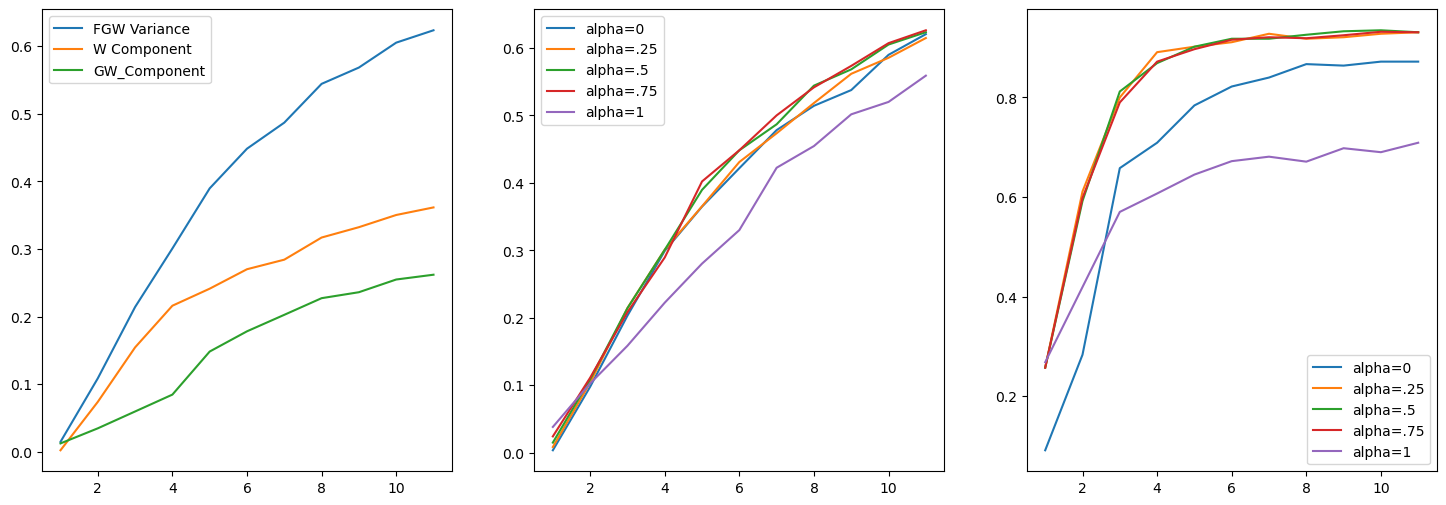

Experiment N = 12 , alpha = 0
Iteration 1: 0.9045535254007363, 54.51 seconds
Iteration 2: 0.62474011868956, 54.56 seconds
Iteration 3: 0.6326292160142963, 54.42 seconds
Iteration 4: 0.6381652265708728, 54.13 seconds
Iteration 5: 0.6426119973895781, 54.38 seconds
Iteration 6: 0.6428444922043899, 54.31 seconds
Iteration 7: 0.6430712824000275, 54.27 seconds
Iteration 8: 0.643367793712365, 53.36 seconds
Iteration 9: 0.6434656407319778, 53.85 seconds
Iteration 10: 0.6434806288121006, 54.15 seconds
0.878 Experiment N = 12 , alpha = 0.25
Iteration 1: 0.9165423435926051, 57.74 seconds
Iteration 2: 0.6297371161817629, 57.42 seconds
Iteration 3: 0.6264940036075693, 57.22 seconds
Iteration 4: 0.6265466176866643, 57.3 seconds
Iteration 5: 0.6306630169663784, 57.32 seconds
Iteration 6: 0.6365134558329442, 57.33 seconds
Iteration 7: 0.6399422146147212, 57.25 seconds
Iteration 8: 0.6422208131402019, 57.81 seconds
Iteration 9: 0.6435615019421661, 57.84 seconds
Iteration 10: 0.6446528005619597, 58.22 s

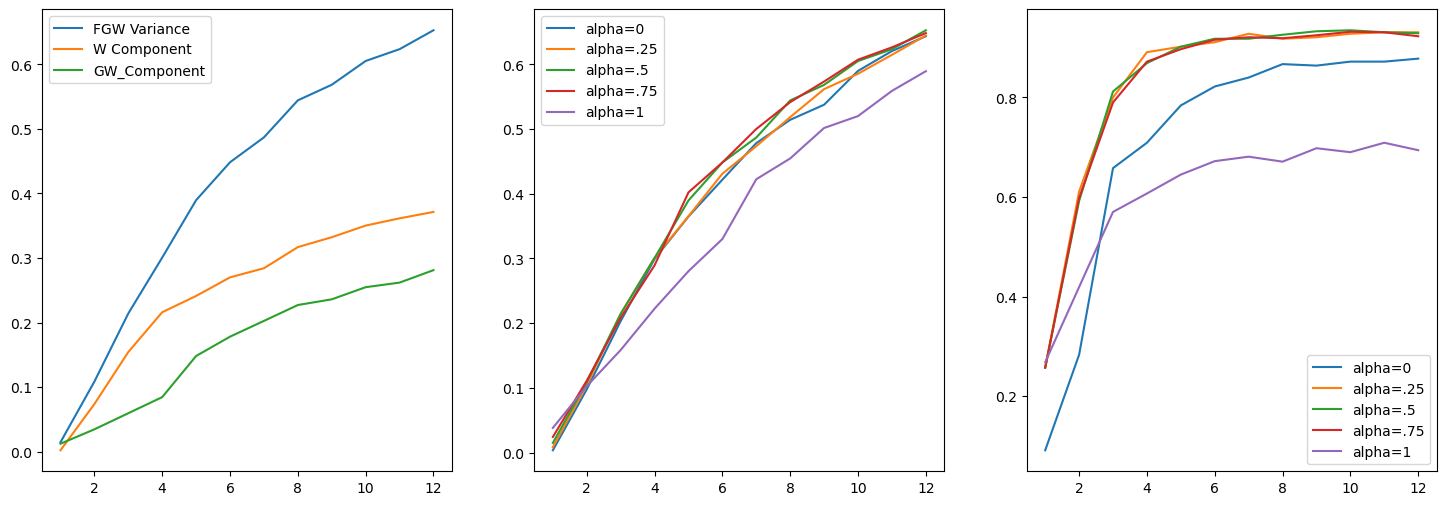

Experiment N = 13 , alpha = 0
Iteration 1: 0.938510503984424, 61.34 seconds
Iteration 2: 0.638708747908384, 61.55 seconds
Iteration 3: 0.635987663630484, 61.92 seconds
Iteration 4: 0.6390460375557744, 61.76 seconds
Iteration 5: 0.6387504742855115, 61.62 seconds
Iteration 6: 0.640576757227681, 61.52 seconds
Iteration 7: 0.6424055422992986, 61.01 seconds
Iteration 8: 0.6437291959336091, 61.63 seconds
Iteration 9: 0.6445205161839223, 63.74 seconds
Iteration 10: 0.6447694259976896, 62.9 seconds
0.886 Experiment N = 13 , alpha = 0.25
Iteration 1: 0.9523466714566844, 64.93 seconds
Iteration 2: 0.6403647362545548, 64.05 seconds
Iteration 3: 0.6356180195768905, 64.22 seconds
Iteration 4: 0.6378113589917127, 64.1 seconds
Iteration 5: 0.6378521026664016, 64.77 seconds
Iteration 6: 0.639669472520789, 65.01 seconds
Iteration 7: 0.642954538666657, 64.95 seconds
Iteration 8: 0.6457758634461335, 64.35 seconds
Iteration 9: 0.6473166163989074, 64.07 seconds
Iteration 10: 0.6494682746151949, 64.22 secon

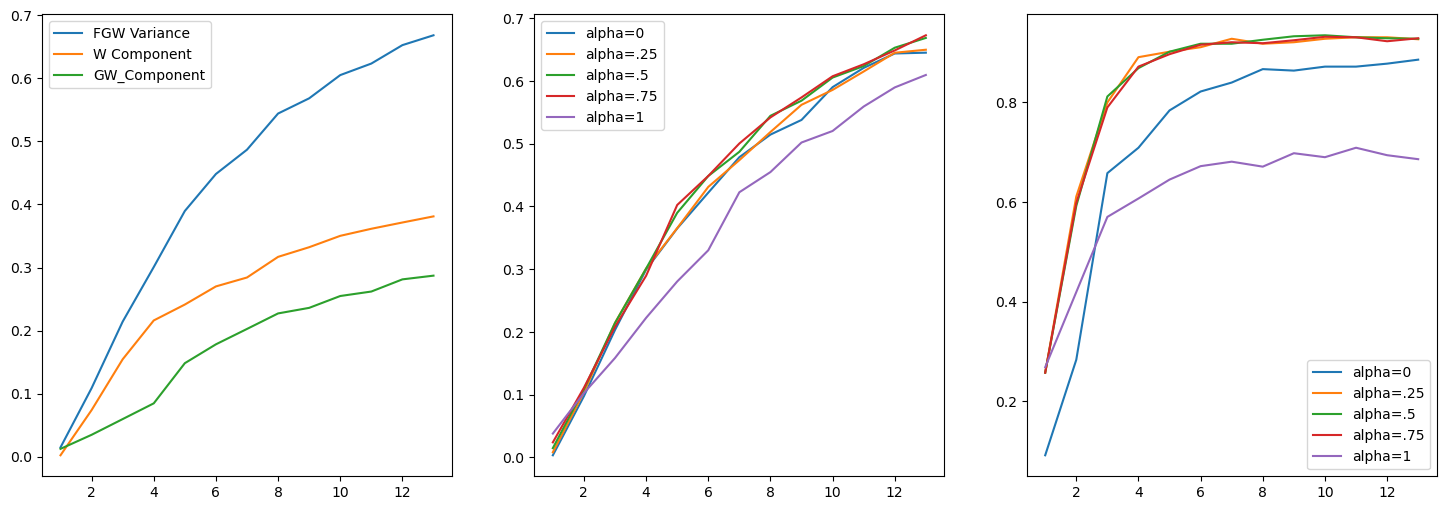

Experiment N = 14 , alpha = 0
Iteration 1: 0.8697024555400863, 67.75 seconds
Iteration 2: 0.662922575871037, 68.08 seconds
Iteration 3: 0.6579996317984116, 68.14 seconds
Iteration 4: 0.6647974996064688, 68.18 seconds
Iteration 5: 0.6697208025184608, 68.37 seconds
Iteration 6: 0.6762474689191112, 68.73 seconds
Iteration 7: 0.678531153038915, 68.55 seconds
Iteration 8: 0.6806769231783801, 68.46 seconds
Iteration 9: 0.6804939849568601, 68.7 seconds
Iteration 10: 0.680109900012522, 68.78 seconds
0.881 Experiment N = 14 , alpha = 0.25
Iteration 1: 0.9298736725678989, 72.02 seconds
Iteration 2: 0.667695488390474, 72.24 seconds
Iteration 3: 0.664515742827096, 72.17 seconds
Iteration 4: 0.6644927212984078, 72.21 seconds
Iteration 5: 0.665171671906178, 72.13 seconds
Iteration 6: 0.6664552333785102, 72.19 seconds
Iteration 7: 0.6663660769112085, 71.87 seconds
Iteration 8: 0.6661498545246448, 71.89 seconds
Iteration 9: 0.6664803861126293, 72.15 seconds
Iteration 10: 0.6666474154257306, 72.47 seco

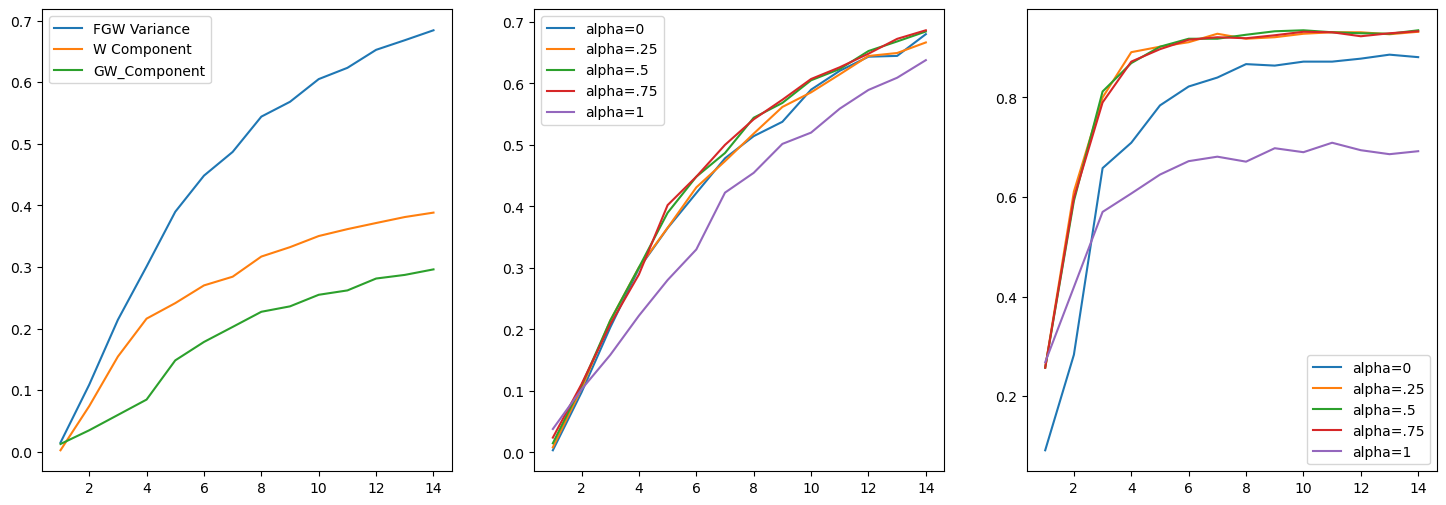

Experiment N = 20 , alpha = 0
Iteration 1: 0.9474498668203509, 125.05 seconds
Iteration 2: 0.7395297245411511, 124.42 seconds
Iteration 3: 0.7406537656667782, 124.17 seconds
Iteration 4: 0.741208775237171, 122.18 seconds
Iteration 5: 0.7409179274097705, 122.26 seconds
Iteration 6: 0.7406843926916696, 121.85 seconds
Iteration 7: 0.7419911586679686, 123.0 seconds
Iteration 8: 0.7424479405958421, 122.56 seconds
Iteration 9: 0.7425979901362912, 123.07 seconds
Iteration 10: 0.7418857215406623, 126.87 seconds
0.891 Experiment N = 20 , alpha = 0.25
Iteration 1: 0.9474037750422482, 137.61 seconds
Iteration 2: 0.7418126670809996, 133.73 seconds
Iteration 3: 0.7402716869081004, 122.13 seconds
Iteration 4: 0.741192739642582, 105.89 seconds
Iteration 5: 0.7434856469380311, 105.82 seconds
Iteration 6: 0.7453941772113102, 106.29 seconds
Iteration 7: 0.7456998136824999, 105.79 seconds
Iteration 8: 0.745888645254408, 105.75 seconds
Iteration 9: 0.7468406032682863, 106.12 seconds
Iteration 10: 0.747394

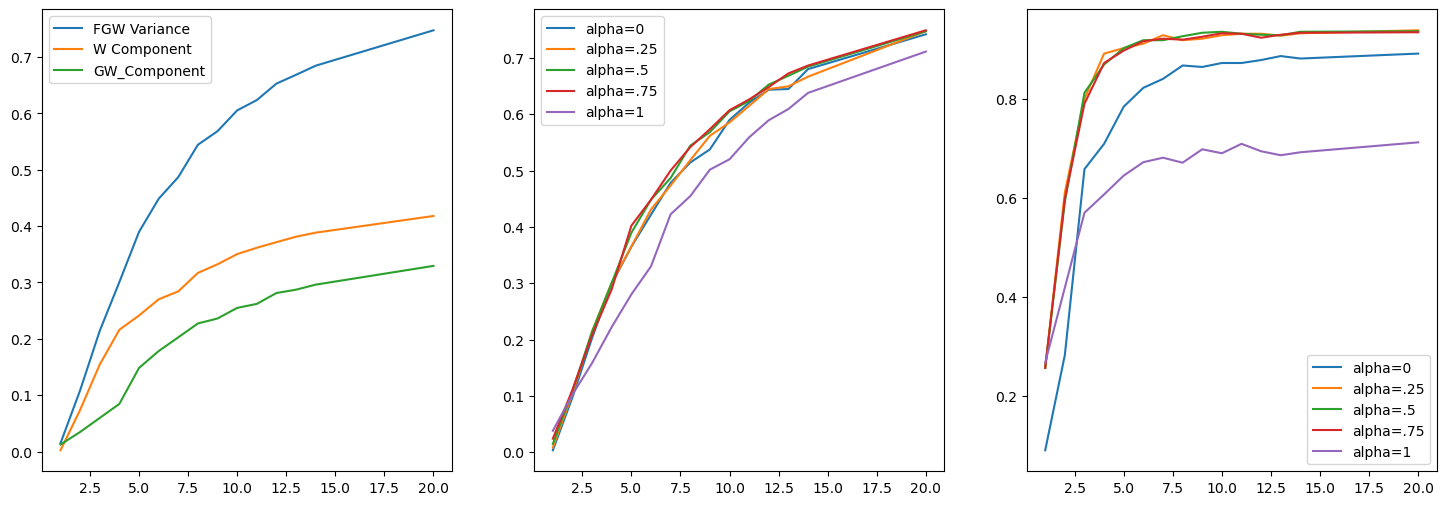

Experiment N = 30 , alpha = 0
Iteration 1: 0.9703050100423639, 226.79 seconds
Iteration 2: 0.8095154418263403, 227.23 seconds
Iteration 3: 0.8119201380489259, 226.92 seconds
Iteration 4: 0.8118319378026456, 227.27 seconds
Iteration 5: 0.8131682774624924, 226.86 seconds
Iteration 6: 0.8127095352748922, 227.01 seconds
Iteration 7: 0.8138884659133738, 227.04 seconds
Iteration 8: 0.8146596961849297, 226.91 seconds
Iteration 9: 0.8148658938019087, 227.46 seconds
Iteration 10: 0.8149142882805097, 226.82 seconds
0.892 Experiment N = 30 , alpha = 0.25
Iteration 1: 0.9662486972490074, 235.28 seconds
Iteration 2: 0.8093568085099587, 234.27 seconds
Iteration 3: 0.8065286938648089, 234.12 seconds
Iteration 4: 0.8071782320797094, 235.1 seconds
Iteration 5: 0.8084107252477158, 234.79 seconds
Iteration 6: 0.8091591640829533, 234.3 seconds
Iteration 7: 0.8096741865508383, 234.85 seconds
Iteration 8: 0.8102494566771477, 234.88 seconds
Iteration 9: 0.8097630047313928, 235.01 seconds
Iteration 10: 0.8103

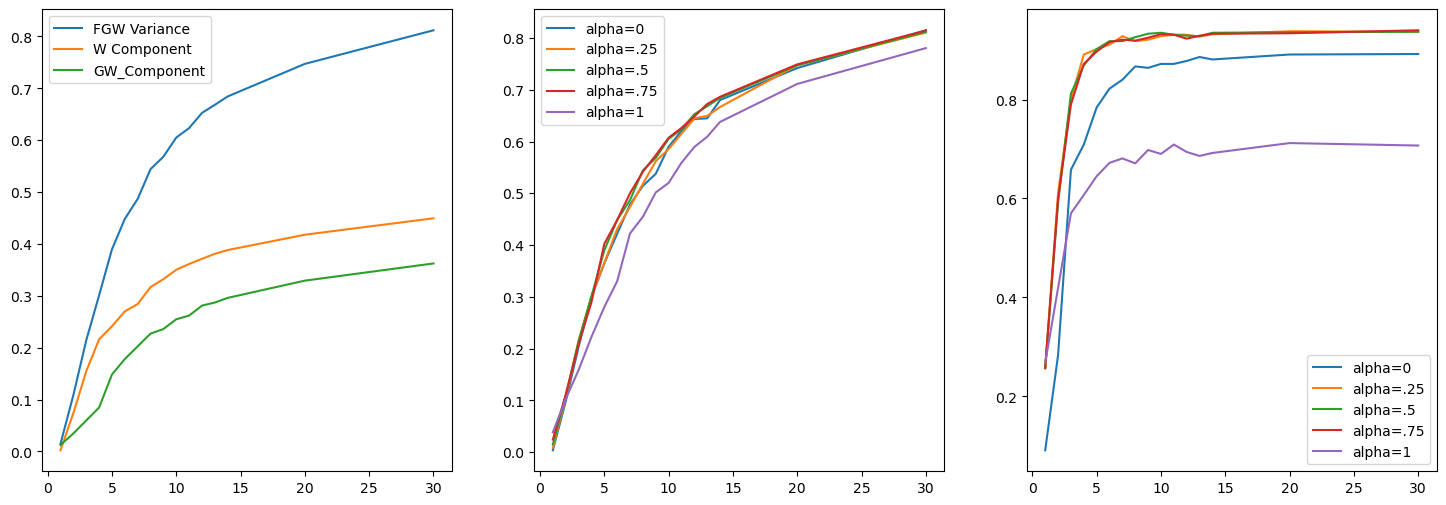

Experiment N = 40 , alpha = 0
Iteration 1: 0.9642679043454684, 396.52 seconds
Iteration 2: 0.8475874927041418, 396.89 seconds
Iteration 3: 0.851327632318391, 407.04 seconds
Iteration 4: 0.853116105620578, 398.72 seconds
Iteration 5: 0.8539028307287465, 400.38 seconds
Iteration 6: 0.8539323226214734, 399.5 seconds
Iteration 7: 0.853995094442176, 400.91 seconds
Iteration 8: 0.8539116191806627, 408.72 seconds
Iteration 9: 0.853921393706044, 408.64 seconds
Iteration 10: 0.8538659319103244, 409.14 seconds
0.897 Experiment N = 40 , alpha = 0.25
Iteration 1: 0.9748256166787803, 419.82 seconds
Iteration 2: 0.8505281390160782, 418.59 seconds
Iteration 3: 0.8512908302845127, 417.01 seconds
Iteration 4: 0.8524655089520403, 417.72 seconds
Iteration 5: 0.8531774778073342, 422.09 seconds
Iteration 6: 0.8529768107747836, 418.61 seconds
Iteration 7: 0.853509172347602, 417.49 seconds
Iteration 8: 0.8538088317487568, 418.25 seconds
Iteration 9: 0.8538654203562512, 418.85 seconds
Iteration 10: 0.85432688

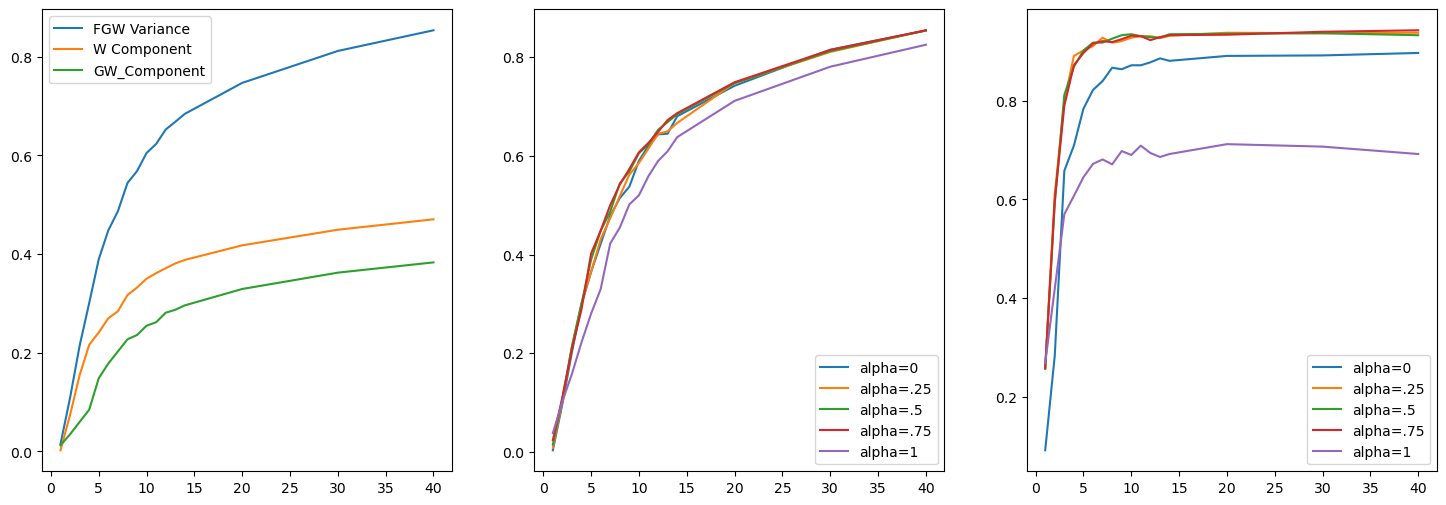

Experiment N = 50 , alpha = 0
Iteration 1: 0.9725610679258163, 625.23 seconds
Iteration 2: 0.8748547787958249, 624.31 seconds
Iteration 3: 0.8783829906205496, 624.88 seconds
Iteration 4: 0.8789074244045766, 623.8 seconds
Iteration 5: 0.8792544737768685, 624.68 seconds
Iteration 6: 0.8792358229417913, 624.64 seconds
Iteration 7: 0.8792302813522472, 625.05 seconds
Iteration 8: 0.8795218643566562, 624.09 seconds
Iteration 9: 0.8793409065026124, 614.64 seconds
Iteration 10: 0.8793517938223437, 613.78 seconds
0.898 Experiment N = 50 , alpha = 0.25
Iteration 1: 0.9723548655413757, 625.54 seconds
Iteration 2: 0.876406541851521, 624.97 seconds
Iteration 3: 0.8774694870679189, 624.75 seconds
Iteration 4: 0.8782260406367123, 624.52 seconds
Iteration 5: 0.8787090165341059, 625.53 seconds
Iteration 6: 0.8790761715905828, 623.72 seconds
Iteration 7: 0.8794310489697997, 624.8 seconds
Iteration 8: 0.8797426907884001, 627.14 seconds
Iteration 9: 0.8798451878482406, 626.03 seconds
Iteration 10: 0.87985

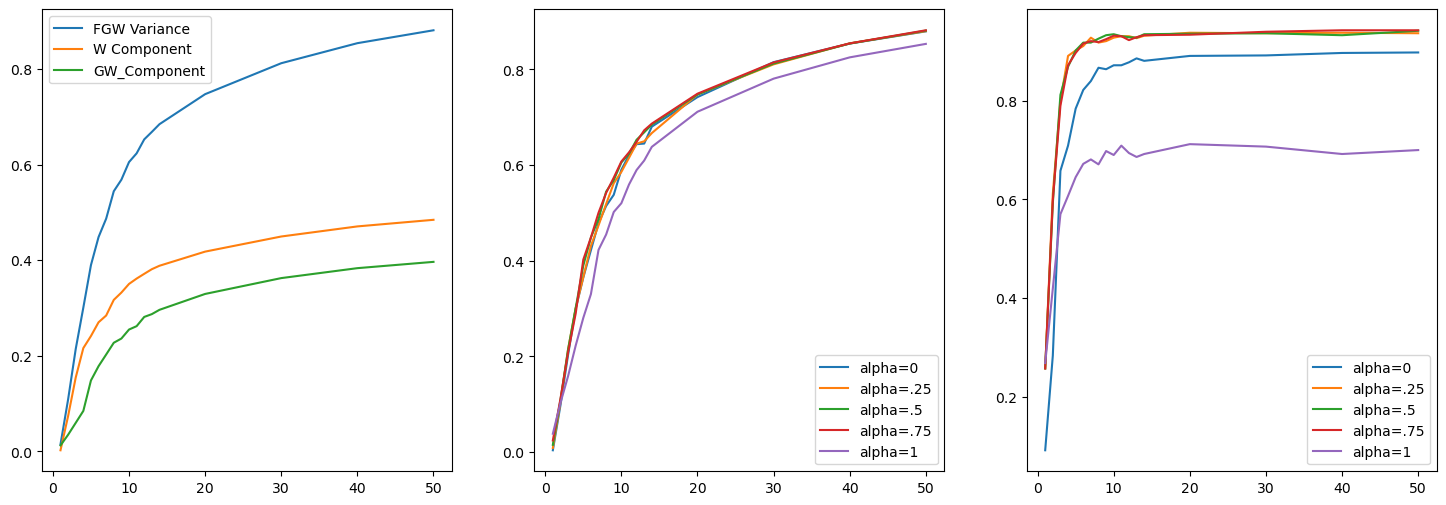

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, LeaveOneOut

data_list=[] #deterministic component
data_list_W=[] #Wasserstein component of deterministic component
data_list_GW=[] #GW component of deterministic component
FGW_list=[] #mean squared FGW
acc_list=[] #SVM accuracy

mdl = SVC()
y = labels

N_range = np.concatenate([np.arange(1,15),[20,30,40,50]])

for i, N in enumerate(N_range):
    
    data_list.append([]) 
    data_list_W.append([])
    data_list_GW.append([])
    FGW_list.append([])
    acc_list.append([])
    
    for alpha in [0,0.25,.5,.75,1]:
        print("Experiment N =",N,", alpha =",alpha)
        mu0, squared_FGW_2, deterministic_component, deterministic_component_W, deterministic_component_GW, gamma_list, nodes, edges = FGW_decomp(measure_list,alpha=alpha,N=N)
        with open('data_files//MNIST_decomp_experiment2//experiment_N_'+str(N)+'_alpha_'+str(alpha)+'.pkl', 'wb') as f:  
            pickle.dump([mu0, squared_FGW_2, deterministic_component, deterministic_component_W, deterministic_component_GW, gamma_list, nodes, edges], f)
        
        #store percent variance explained by LOT embedding
        data_list[-1].append(np.mean(deterministic_component)/np.mean(squared_FGW_2))
        data_list_W[-1].append(np.mean(deterministic_component_W)/np.mean(squared_FGW_2))
        data_list_GW[-1].append(np.mean(deterministic_component_GW)/np.mean(squared_FGW_2))
        FGW_list[-1].append(np.mean(squared_FGW_2))
        
        #build classifer on LOT embedded data, store accuracy
        if alpha == 0:
            X = nodes.reshape(nodes.shape[0],-1)
        elif alpha == 1:
            upper_triangle_indices = np.triu_indices(edges.shape[1])
            X = edges[:, upper_triangle_indices[0], upper_triangle_indices[1]]
        else:
            X = vectorize_structured_data(nodes,edges,mu0)
        acc = np.mean(cross_val_score(mdl,X,y,cv=LeaveOneOut()))
        acc_list[-1].append(acc)
        print(acc, end = ' ')
    print(" ")
        
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(N_range[:i+1],np.array(data_list)[:,2])
    plt.plot(N_range[:i+1],np.array(data_list_W)[:,2])
    plt.plot(N_range[:i+1],np.array(data_list_GW)[:,2])
    plt.legend(["FGW Variance", "W Component", "GW_Component"])
    plt.title("")
    
    plt.subplot(1,3,2)
    plt.plot(N_range[:i+1],np.array(data_list))
    
    plt.legend(["alpha=0","alpha=.25","alpha=.5","alpha=.75","alpha=1"])
    plt.subplot(1,3,3)
    plt.plot(N_range[:i+1],np.array(acc_list))
    plt.legend(["alpha=0","alpha=.25","alpha=.5","alpha=.75","alpha=1"])
    plt.show()
        
        
        

In [9]:
np.save("data_files/mnist_fgw_FGW_list.npy", FGW_list)
np.save("data_files/mnist_fgw_data_list_W.npy", data_list_W)
np.save("data_files/mnist_fgw_data_list_GW.npy", data_list_GW)
np.save("data_files/mnist_fgw_data_list.npy", data_list)
np.save("data_files/mnist_fgw_acc_list.npy", acc_list)

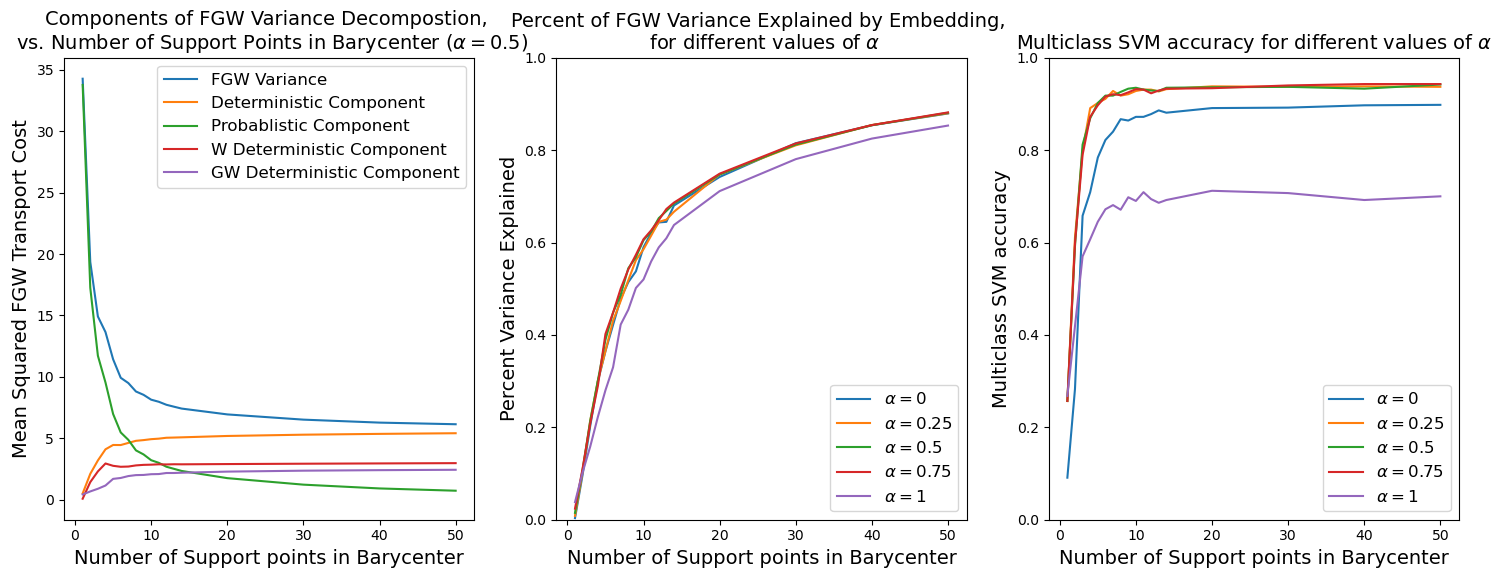

In [80]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fs=14

plt.figure(figsize=(18,6))

plt.subplot(1,3,2)
plt.plot(N_range,np.array(data_list))
plt.ylim(0,1)
plt.legend([r'$\alpha=0$',r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$',r'$\alpha=1$'],fontsize=fs-2)
plt.title("Percent of FGW Variance Explained by Embedding, \n for different values of "+r"$\alpha$", fontsize=fs)
plt.xlabel("Number of Support points in Barycenter", fontsize=fs)
plt.ylabel("Percent Variance Explained", fontsize=fs)

plt.subplot(1,3,3)
plt.plot(N_range,np.array(acc_list))
plt.legend([r'$\alpha=0$',r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$',r'$\alpha=1$'],fontsize=fs-2)
plt.title("Multiclass SVM accuracy for different values of "+r"$\alpha$", fontsize=fs)
plt.xlabel("Number of Support points in Barycenter", fontsize=fs)
plt.ylabel("Multiclass SVM accuracy", fontsize=fs)
plt.ylim(0,1)

plt.subplot(1,3,1)

ax = plt.gca()
ax.plot(N_range,np.array(FGW_list)[:,2])
ax.plot(N_range,np.array(data_list)[:,2]*np.array(FGW_list)[:,2])
ax.plot(N_range,np.array(FGW_list)[:,2]-(np.array(data_list)[:,2]*np.array(FGW_list)[:,2]))
ax.plot(N_range,np.array(data_list_W)[:,2]*np.array(FGW_list)[:,2])
ax.plot(N_range,np.array(data_list_GW)[:,2]*np.array(FGW_list)[:,2])

# zoom = 2  # specify the zoom level
# inset_ax = zoomed_inset_axes(plt.gca(), zoom)#, loc='upper right')

# # Zoom in on a portion of the data
# x1, x2, y1, y2 = 0, 10, 0, 5  # specify the bounds for the zoomed region
# inset_ax.set_xlim(x1, x2)
# inset_ax.set_ylim(y1, y2)

ax.legend(["FGW Variance", "Deterministic Component", "Probablistic Component", "W Deterministic Component", "GW Deterministic Component"],fontsize=fs-2)
ax.set_title("Components of FGW Variance Decompostion, \n vs. Number of Support Points in Barycenter "+r"($\alpha = 0.5$)", fontsize=fs)
ax.set_xlabel("Number of Support points in Barycenter", fontsize=fs)
ax.set_ylabel("Mean Squared FGW Transport Cost", fontsize=fs)

# plt.show()
plt.savefig("MNIST_fgw_experiment.png", bbox_inches = 'tight')


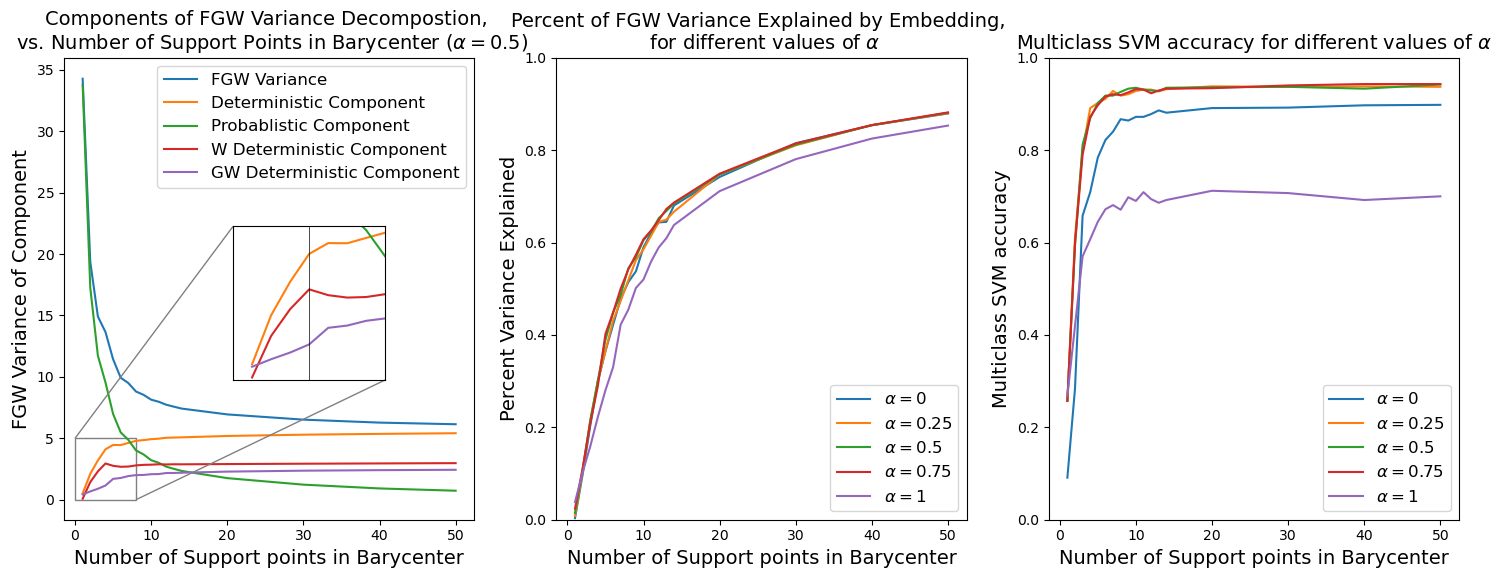

In [74]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fs=14

plt.figure(figsize=(18,6))

plt.subplot(1,3,2)
plt.plot(N_range,np.array(data_list))
plt.ylim(0,1)
plt.legend([r'$\alpha=0$',r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$',r'$\alpha=1$'],fontsize=fs-2)
plt.title("Percent of FGW Variance Explained by Embedding, \n for different values of "+r"$\alpha$", fontsize=fs)
plt.xlabel("Number of Support points in Barycenter", fontsize=fs)
plt.ylabel("Percent Variance Explained", fontsize=fs)

plt.subplot(1,3,3)
plt.plot(N_range,np.array(acc_list))
plt.legend([r'$\alpha=0$',r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$',r'$\alpha=1$'],fontsize=fs-2)
plt.title("Multiclass SVM accuracy for different values of "+r"$\alpha$", fontsize=fs)
plt.xlabel("Number of Support points in Barycenter", fontsize=fs)
plt.ylabel("Multiclass SVM accuracy", fontsize=fs)
plt.ylim(0,1)

plt.subplot(1,3,1)

ax = plt.gca()
ax.plot(N_range,np.array(FGW_list)[:,2])
ax.plot(N_range,np.array(data_list)[:,2]*np.array(FGW_list)[:,2])
ax.plot(N_range,np.array(FGW_list)[:,2]-(np.array(data_list)[:,2]*np.array(FGW_list)[:,2]))
ax.plot(N_range,np.array(data_list_W)[:,2]*np.array(FGW_list)[:,2])
ax.plot(N_range,np.array(data_list_GW)[:,2]*np.array(FGW_list)[:,2])

# zoom = 2  # specify the zoom level
# inset_ax = zoomed_inset_axes(plt.gca(), zoom)#, loc='upper right')

# # Zoom in on a portion of the data
# x1, x2, y1, y2 = 0, 10, 0, 5  # specify the bounds for the zoomed region
# inset_ax.set_xlim(x1, x2)
# inset_ax.set_ylim(y1, y2)

ax.legend(["FGW Variance", "Deterministic Component", "Probablistic Component", "W Deterministic Component", "GW Deterministic Component"],fontsize=fs-2)
ax.set_title("Components of FGW Variance Decompostion, \n vs. Number of Support Points in Barycenter "+r"($\alpha = 0.5$)", fontsize=fs)
ax.set_xlabel("Number of Support points in Barycenter", fontsize=fs)
ax.set_ylabel("FGW Variance of Component", fontsize=fs)


# ax = plt.gca()
zoom = 2.5  # specify the zoom level
inset_ax = zoomed_inset_axes(ax, zoom, bbox_to_anchor=(.8, .65, 0, 0), bbox_transform=ax.transAxes)#,loc='center right')

inset_ax.plot(N_range,np.array(FGW_list)[:,2])
inset_ax.plot(N_range,np.array(data_list)[:,2]*np.array(FGW_list)[:,2])
inset_ax.plot(N_range,np.array(FGW_list)[:,2]-(np.array(data_list)[:,2]*np.array(FGW_list)[:,2]))
inset_ax.plot(N_range,np.array(data_list_W)[:,2]*np.array(FGW_list)[:,2])
inset_ax.plot(N_range,np.array(data_list_GW)[:,2]*np.array(FGW_list)[:,2])
inset_ax.axvline(4,c='black',linewidth=.5)

# Zoom in on a portion of the data
x1, x2, y1, y2 = 0, 8, 0, 5  # specify the bounds for the zoomed region
inset_ax.set_xlim(x1, x2)
inset_ax.set_ylim(y1, y2)

plt.xticks([])
plt.yticks([])

# Mark the inset region on the main plot
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

# plt.show()
plt.savefig("MNIST_fgw_experiment_inset.png", bbox_inches = 'tight')


